In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from unet import Unet
from constant import IMAGENET_MEAN, IMAGENET_STD
from fastai.conv_learner import *
from tqdm import tqdm

from pathlib import Path
from PIL import Image
from scipy import ndimage
import skimage
from torchvision.transforms import transforms

In [3]:
PATH = Path('/home/dattran/data/xray-thesis/chestX-ray14')
IMAGE_DN = 'images'
CROPPED_DN = 'cropped'
CSV = 'test.csv'

df = pd.read_csv(PATH/CSV, header=None, sep=' ')
image_names = df.iloc[:, 0].values

In [4]:
unet_model = '20190211-101020'
unet = Unet(trained=True, model_name=unet_model).cuda()
unet.eval();

In [5]:
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
toTensor = transforms.ToTensor()
tfm = transforms.Compose([
    transforms.Resize(256),
    toTeknsor,
    normalize
])

NameError: name 'toTeknsor' is not defined

In [ ]:
d = {}
distorted_lung = []
for image_name in tqdm(image_names):
    image = Image.open(PATH/IMAGE_DN/image_name).convert('RGB')
    py = unet(V(tfm(image)[None]))
    py = (py[0].cpu() > 0.5).type(torch.FloatTensor)
    
    try: # some image dont have shape
        labels = skimage.measure.label(py[0].numpy())
        idx = np.argsort(-np.bincount(labels.flat)) # get index of each label
        mask = np.logical_or(labels==idx[1], labels==idx[2]).astype(np.float32) # left nd right lung, 0 for background
        mask = cv2.resize(mask, (1024, 1024))
        slice_y, slice_x = ndimage.find_objects(mask, 1)[0]
        h, w = slice_y.stop - slice_y.start, slice_x.stop - slice_x.start
        ratio = w*1./h
        
        nw, nh = int(w/0.875), int(h/0.875)
        dw, dh = (nw-w)//2, (nh-h)//2
        t = max(slice_y.start-dh, 0)
        l = max(slice_x.start-dw, 0)
        b = min(slice_y.stop+dh, 1024)
        r = min(slice_x.stop+dw, 1024)
        d[image_name] = f'{l} {t} {r} {b}'

    except Exception as e:
#         print(e)
        # distorted lung, .. (or 2 lung stick: just a few)
        # in that case, get all image
        d[image_name] = f'0 0 1024 1024'
        distorted_lung.append(image_name)
    
with open(PATH/'cut_all.pickle', 'wb') as f:
    pickle.dump(d, f)

In [59]:
# distort lung image, only 1 lung is visible, 2 lungs stick 
distorted_lung = ['00022526_007.png',
 '00004724_009.png',
 '00027415_066.png',
 '00027415_067.png',
 '00018284_021.png',
 '00018284_022.png',
 '00010007_038.png',
 '00010007_141.png',
 '00002237_001.png',
 '00001986_000.png',
 '00001986_001.png',
 '00001986_002.png',
 '00001986_003.png',
 '00001986_004.png',
 '00001986_005.png',
 '00001986_006.png',
 '00001986_007.png',
 '00001986_008.png',
 '00001986_009.png',
 '00001986_011.png',
 '00001986_012.png',
 '00001986_013.png',
 '00001986_014.png',
 '00006404_000.png',
 '00002413_000.png',
 '00002413_001.png',
 '00002413_002.png',
 '00002413_003.png',
 '00001278_014.png',
 '00016743_008.png',
 '00016743_016.png',
 '00016743_018.png',
 '00016743_020.png',
 '00012263_008.png',
 '00012263_009.png',
 '00015758_001.png',
 '00015758_002.png',
 '00015758_003.png',
 '00015758_005.png',
 '00015758_006.png',
 '00015758_007.png',
 '00015758_009.png',
 '00015758_010.png',
 '00015758_011.png',
 '00015758_013.png',
 '00000797_002.png',
 '00016732_005.png',
 '00012628_028.png',
 '00014018_016.png',
 '00014018_018.png',
 '00014018_020.png',
 '00014018_021.png',
 '00015212_000.png',
 '00004832_007.png',
 '00027561_001.png',
 '00002827_000.png',
 '00022891_001.png',
 '00012525_001.png',
 '00012525_002.png',
 '00005936_010.png',
 '00009198_000.png',
 '00009198_001.png',
 '00009198_003.png',
 '00009198_004.png',
 '00009198_005.png',
 '00020450_025.png',
 '00020450_026.png']
len(distorted_lung)

67

In [5]:
with open(PATH/'cut_all.pickle', 'rb') as f:
    a = pickle.load(f)

In [6]:
ratios = []
long_lung_files = []
normal_lung_files = []
short_lung_files = []
for k, v in a.items():
    coords = list(map(lambda x: int(x), v.split(' ')))
    w, h = coords[2] - coords[0], coords[3] - coords[1]
    ratio = w*1./h
    if ratio < 0.8:long_lung_files.append(k)
    elif ratio < 1.5: normal_lung_files.append(k)
    else: short_lung_files.append(k)
    ratios.append(ratio)
    

In [51]:
max(ratios), min(ratios), np.mean(ratios)

(2.742138364779874, 0.42857142857142855, 1.1182401572007745)

(array([    9.,  1746., 10378.,  7679.,  1897.,   247.,    28.,     2.,     2.,     1.]),
 array([0.42857, 0.65993, 0.89128, 1.12264, 1.354  , 1.58535, 1.81671, 2.04807, 2.27942, 2.51078, 2.74214]),
 <a list of 10 Patch objects>)

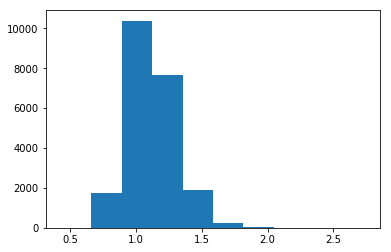

In [54]:
plt.hist(ratios)

In [95]:
image_files = random.sample(distorted_lung, 18)

In [10]:
from skimage import morphology, color
from matplotlib.patches import Rectangle

def plot_lung_segment(image, mask, gt_mask=None, ax=None, boundary=False):
    if not ax: fig, ax = plt.subplots(figsize=(12, 10))
    image = blend_segmentation(image, mask, gt_mask, boundary, alpha=1)
    ax.imshow(image)
#     ax.imshow(image)
#     if boundary: mask = morphology.dilation(mask, morphology.disk(3)) - mask
#     ax.imshow(mask, alpha=0.4, vmin=0, vmax=1, cmap='Reds')
#     if gt_mask is not None:
#         boundary = morphology.dilation(gt_mask, morphology.disk(3)) - gt_mask
#         ax.imshow(boundary, alpha=0.4, vmin=0, vmax=1, cmap='Greens')
    ax.set_axis_off()

def blend_segmentation(image, mask, gt_mask=None, boundary=False, alpha=1):
    h, w = image.size
    color_mask = np.zeros((h, w, 3)) # PIL Image
    if boundary: mask = morphology.dilation(mask, morphology.disk(3)) - mask
    color_mask[mask==1] = [1, 0, 0] # RGB
    
    if gt_mask is not None:
        gt_boundary = morphology.dilation(gt_mask, morphology.disk(3)) - gt_mask
        color_mask[gt_boundary==1] = [0, 1, 0] # RGB
    
    image_hsv = color.rgb2hsv(image)
    color_mask_hsv = color.rgb2hsv(color_mask)
    
    image_hsv[..., 0] = color_mask_hsv[..., 0]
    image_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    
    return color.hsv2rgb(image_hsv)
    

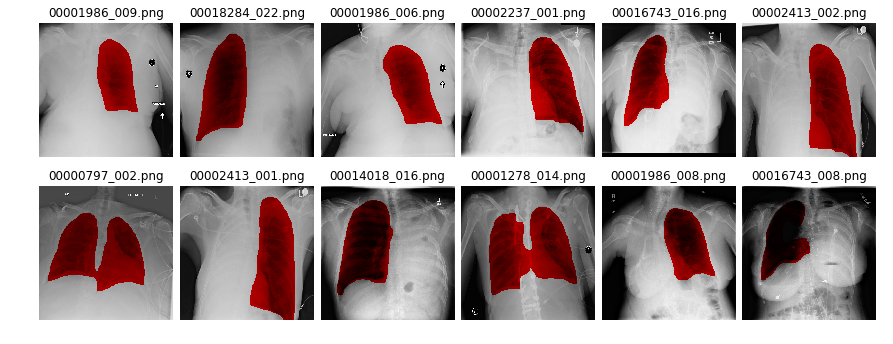

In [97]:
fig, axes = plt.subplots(2, 6, figsize=(15, 6))
kernel = np.ones((10, 10))

for i, ax in enumerate(axes.flat):
    if i >= len(image_files): break
        
    image = Image.open(PATH/IMAGE_DN/image_files[i]).convert('RGB')    
    ax.set_title(image_files[i])

    image_v = V(tfm(image)[None])
    py = torch.sigmoid(unet(image_v))
    py = (py[0].cpu() > 0.5).type(torch.FloatTensor) # 1, 256, 256
    
    # Remove unwatned noise 
#     labels = skimage.measure.label(py[0].numpy()) # 256, 256
#     idx = np.argsort(-np.bincount(labels.flat))
#     mask = np.logical_or(labels==idx[1], labels==idx[2]).astype(np.float32)
#     mask = cv2.resize(mask, (1024, 1024))
    mask = py[0].numpy()
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.resize(mask, (1024, 1024))
    plot_lung_segment(image, mask, ax=ax)

#     slice_y, slice_x = ndimage.find_objects(mask, 1)[0]
#     xy = (slice_x.start, slice_y.start)
#     height = slice_y.stop - slice_y.start
#     width= slice_x.stop - slice_x.start
#     rect = Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)
    plt.subplots_adjust(wspace=0.05, hspace=0.001)
# fig.savefig('normal_lung.png')
fig.savefig('segment_fail.png')

In [93]:
# noise: '00026098_006.png', '00016716_013.png', '00000402_007.png', '00004881_005.png'
# hole: '00008844_000.png'
# fused: 
image_files[12]

'00002121_000.png'

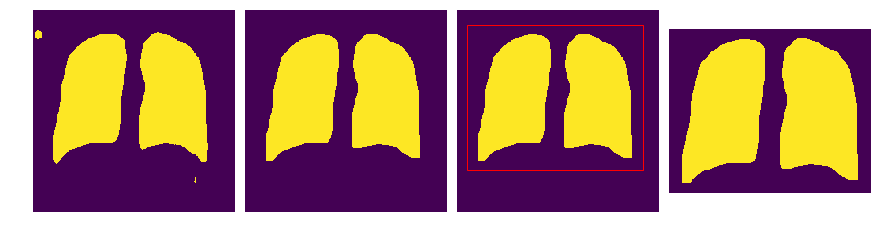

In [94]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 6))
image_file = '00002121_000.png'
kernel = np.ones((10, 10))
        
fig = plt.figure(figsize=(15, 24))
image = Image.open(PATH/IMAGE_DN/image_file).convert('RGB')    
image_v = V(tfm(image)[None])
py = torch.sigmoid(unet(image_v))
py = (py[0].cpu() > 0.5).type(torch.FloatTensor) # 1, 256, 256
mask = py[0].numpy()
ax = fig.add_subplot(141)
ax.imshow(mask)
ax.set_axis_off()

mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
ax = fig.add_subplot(142)
ax.imshow(mask)
ax.set_axis_off()

# labels = skimage.measure.label(py[0].numpy()) # 256, 256
# idx = np.argsort(-np.bincount(labels.flat))
# mask = np.logical_or(labels==idx[1], labels==idx[2]).astype(np.float32)
# mask = cv2.resize(mask, (1024, 1024))

# plot_lung_segment(image, mask, ax=ax)

slice_y, slice_x = ndimage.find_objects(mask, 1)[0]
xy = (slice_x.start, slice_y.start)
h, w = slice_y.stop - slice_y.start, slice_x.stop - slice_x.start
nw, nh = int(w/0.875), int(h/0.875)
dw, dh = (nw-w)//2, (nh-h)//2

t = max(slice_y.start-dh, 0)
l = max(slice_x.start-dw, 0)
b = min(slice_y.stop+dh, 1024)
r = min(slice_x.stop+dw, 1024)
rect = Rectangle((l, t), (r-l), (b-t), linewidth=1,edgecolor='r',facecolor='none')

ax = fig.add_subplot(143)
ax.imshow(mask)
ax.add_patch(rect)
ax.set_axis_off()

ax = fig.add_subplot(144)
ax.imshow(mask[t:b, l:r])
ax.set_axis_off()
plt.subplots_adjust(wspace=0.05, hspace=0.001)

fig.savefig('post_lung_seg.png')